<h3 style="color:darkblue;">Deep Learning-Based Brain Tumor Classification Using Fine-Tuned VGG16: A Transfer Learning Approach for Clinical Diagnostic Support</h3>

<h4 style="color:coral;">Importing Libraries, Load & Data Lookup</h4>

In [30]:
# Import libraries
import os
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

In [31]:
# Load Dataset
# Set your dataset directories - use full paths
train_dir = 'C:/Users/User/Desktop/Projects/Data Science/Healthcare/BrainTumor/BrainTumorMRI/Testing'
test_dir = 'C:/Users/User/Desktop/Projects/Data Science/Healthcare/BrainTumor/BrainTumorMRI/Training'

# Function to load data paths and labels
def load_data_paths(data_dir):
    paths = []
    labels = []
    
    if not os.path.exists(data_dir):
        print(f"Directory not found: {data_dir}")
        return paths, labels
    
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for image in os.listdir(label_dir):
                if image.lower().endswith(('.png', '.jpg', '.jpeg')):
                    paths.append(os.path.join(label_dir, image))
                    labels.append(label)
    
    return shuffle(paths, labels, random_state=42)

# Load training data paths
train_paths, train_labels = load_data_paths(train_dir)
print(f"Training samples: {len(train_paths)}")

# Load testing data paths  
test_paths, test_labels = load_data_paths(test_dir)
print(f"Testing samples: {len(test_paths)}")

Training samples: 1311
Testing samples: 5712


In [32]:
# Show class distribution
if train_labels:
    unique_labels = list(set(train_labels))
    print(f"Classes found: {unique_labels}")
    
    for label in unique_labels:
        train_count = train_labels.count(label)
        test_count = test_labels.count(label) if test_labels else 0
        print(f"{label}: {train_count} train, {test_count} test")

Classes found: ['notumor', 'pituitary', 'glioma', 'meningioma']
notumor: 405 train, 1595 test
pituitary: 300 train, 1457 test
glioma: 300 train, 1321 test
meningioma: 306 train, 1339 test


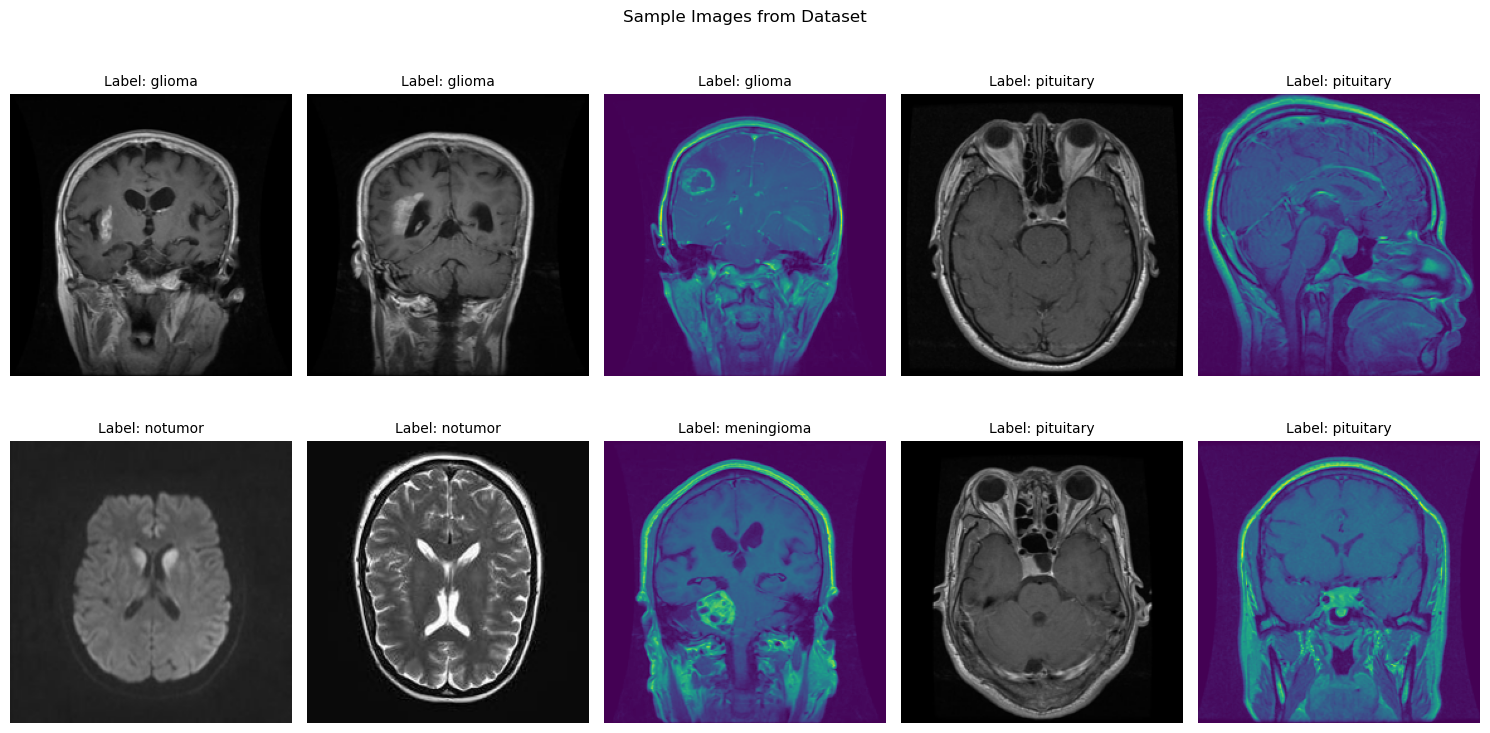

In [33]:
# Display sample images
# Select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle('Sample Images from Dataset')
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    # Load sample image
    img_path = train_paths[idx]
    img = Image.open(img_path)
    img = img.resize((224, 224))

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()

<h4 style="color:coral;">Data Preprocessing</h4>

In [34]:
# Data Preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

# Image augmentation function
def augment_image(image_array, apply_augmentation=True):
    if not apply_augmentation:
        return image_array / 255.0
    
    # Convert to PIL Image for augmentation
    image = Image.fromarray(np.uint8(image_array))
    
    # Apply random brightness and contrast
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
    
    # Convert back to array and normalize
    image_array = np.array(image) / 255.0
    return image_array

In [35]:
# Define the image size
IMG_SIZE = (224, 224)

# Function to load and preprocess images with optional augmentation
def load_and_preprocess_images(image_paths, labels, img_size=IMG_SIZE, augment=False):
    images = []
    processed_labels = []
    
    print(f"Loading {len(image_paths)} images (augmentation: {augment})...")
    
    for i, (path, label) in enumerate(zip(image_paths, labels)):
        try:
            # Load image
            img = load_img(path, target_size=img_size)
            img_array = img_to_array(img)
            
            # Apply augmentation if requested
            img_array = augment_image(img_array, apply_augmentation=augment)
            
            images.append(img_array)
            processed_labels.append(label)
            
            # Progress indicator
            if (i + 1) % 500 == 0:
                print(f"Processed {i + 1}/{len(image_paths)} images")
                
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    return np.array(images), processed_labels

# Load training images with augmentation
print("Loading training data with augmentation...")
X_train, y_train_labels = load_and_preprocess_images(train_paths, train_labels, augment=True)

# Load testing images without augmentation
print("Loading testing data without augmentation...")
X_test, y_test_labels = load_and_preprocess_images(test_paths, test_labels, augment=False)

# Encode labels to numbers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_labels)
y_test = label_encoder.transform(y_test_labels)

# Get number of classes
num_classes = len(label_encoder.classes_)

Loading training data with augmentation...
Loading 1311 images (augmentation: True)...
Processed 500/1311 images
Processed 1000/1311 images
Loading testing data without augmentation...
Loading 5712 images (augmentation: False)...
Processed 500/5712 images
Processed 1000/5712 images
Processed 1500/5712 images
Processed 2000/5712 images
Processed 2500/5712 images
Processed 3000/5712 images
Processed 3500/5712 images
Processed 4000/5712 images
Processed 4500/5712 images
Processed 5000/5712 images
Processed 5500/5712 images


In [36]:
# Insight
# 1311 training images (with augmentation): Augmented to artificially expand the dataset or introduce variability.
# 5712 testing images (without augmentation): No changes, ensuring the test evaluation is accurate and consistent.

In [37]:
# Display results
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {list(label_encoder.classes_)}")
print(f"Label encoding: {dict(zip(label_encoder.classes_, range(num_classes)))}")

Training data shape: (1311, 224, 224, 3)
Training labels shape: (1311,)
Testing data shape: (5712, 224, 224, 3)
Testing labels shape: (5712,)
Number of classes: 4
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']
Label encoding: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


<h4 style="color:coral;">Build & Compile Model</h4>

In [38]:
# Build Model
# Load pre-trained VGG16 model
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model (transfer learning)
for layer in base_model.layers:
    layer.trainable = False

# Fine-tuning - make last few layers trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Build the final model
model = Sequential()
model.add(Input(shape=(224, 224, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [39]:
# Compile the model
import tensorflow as tf

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape               ┃        Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                 │ (None, 7, 7, 512)          │     14,714,688 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ flatten_1 (Flatten)                │ (None, 25088)              │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dropout_2 (Dropout)                │ (None, 25088)              │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dense_2 (Dense)                    │ (None, 128)                │      3,211,392 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dropout_3 (Dropout)                │ (None, 128)                │              0 │
├────────────────────────────────────┼────────────────────────────┼────────────────┤
│ dense_3 (Dense)                    │ (None, 4)                  │            516 │
└────────────────────────────────────┴────────────────────────────┴────────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 10,291,332 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

<h4 style="color:coral;">Model Taining (Auto Save Best Model)</h4>

In [40]:
# Model Training

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Training parameters
EPOCHS = 15
BATCH_SIZE = 32

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_brain_tumor_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint]

# Split training data for validation
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training samples: {len(X_train_split)}")
print(f"Validation samples: {len(X_val_split)}")
print(f"Test samples: {len(X_test)}")

Training samples: 1048
Validation samples: 263
Test samples: 5712


In [41]:
# Set seed value
SEED = 32

# Set seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Train the model
print("Starting training...")
history = model.fit(
    X_train_split, y_train_split,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_split, y_val_split),
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 1.1362 - sparse_categorical_accuracy: 0.5133
Epoch 1: val_loss improved from None to 0.49328, saving model to best_brain_tumor_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 251s 8s/step - loss: 0.8812 - sparse_categorical_accuracy: 0.6317 - val_loss: 0.4933 - val_sparse_categorical_accuracy: 0.7909
Epoch 2/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.3871 - sparse_categorical_accuracy: 0.8366
Epoch 2: val_loss improved from 0.49328 to 0.36960, saving model to best_brain_tumor_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 265s 8s/step - loss: 0.3747 - sparse_categorical_accuracy: 0.8464 - val_loss: 0.3696 - val_sparse_categorical_accuracy: 0.8517
Epoch 3/15
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.2428 - sparse_categorical_accuracy: 0.9102
Epoch 3: val_loss improved from 0.36960 to 0.34889, saving model to best_brain_tumor_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 264s 8s/step - loss: 0.2331 - sparse_categorical_a

<h4 style="color:coral;">Model Evaluation</h4>

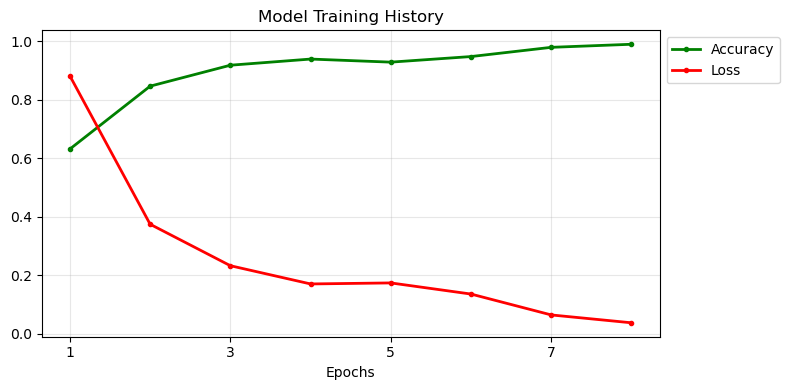

In [42]:
# Plot training history
plt.figure(figsize=(8, 4))
plt.grid(True, alpha=0.3)
plt.plot(history.history['sparse_categorical_accuracy'], '.-g', linewidth=2)
# plt.plot(history.history['val_sparse_categorical_accuracy'], '.-b', linewidth=2)   # Val_accuracy

plt.plot(history.history['loss'], '.-r', linewidth=2)
# plt.plot(history.history['val_loss'], '.-', color='orange', linewidth=2)   # Val_loss
plt.title('Model Training History')
plt.xlabel('Epochs')

plt.xticks(ticks=range(0, len(history.history['loss']), 2),
           labels=[str(i+1) for i in range(0, len(history.history['loss']), 2)])

plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

In [45]:
# Generate Predictions
from tensorflow import keras

# Load model
model = keras.models.load_model('best_brain_tumor_model.keras')

print("Generating predictions... (This will take some time on CPU)")
y_pred_prob = model.predict(X_test, batch_size=128, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

print("Predictions generated! Now you can run the analysis.")

Generating predictions... (This will take some time on CPU)
45/45 ━━━━━━━━━━━━━━━━━━━━ 985s 22s/step
Predictions generated! Now you can run the analysis.


In [46]:
# Classification Report
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.91      0.88      0.90      1321
  meningioma       0.74      0.85      0.79      1339
     notumor       0.96      0.95      0.95      1595
   pituitary       0.95      0.86      0.90      1457

    accuracy                           0.89      5712
   macro avg       0.89      0.89      0.89      5712
weighted avg       0.89      0.89      0.89      5712



Confusion Matrix Values:
[[1163  139   17    2]
 [ 100 1138   36   65]
 [   5   74 1514    2]
 [   8  179   15 1255]]


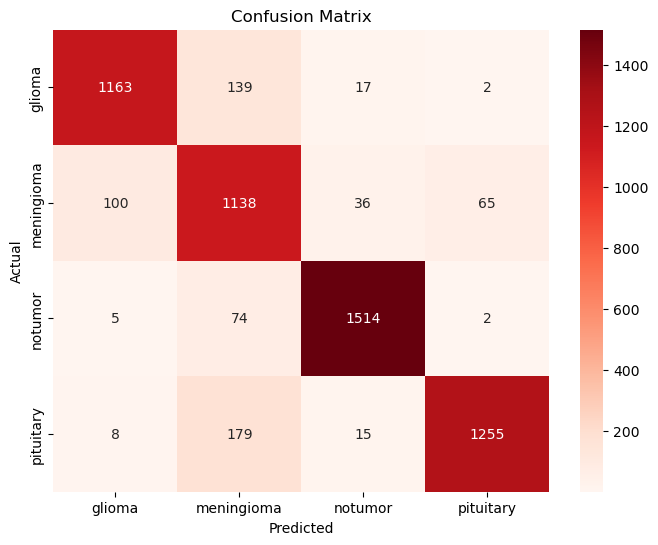

In [47]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix Values:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

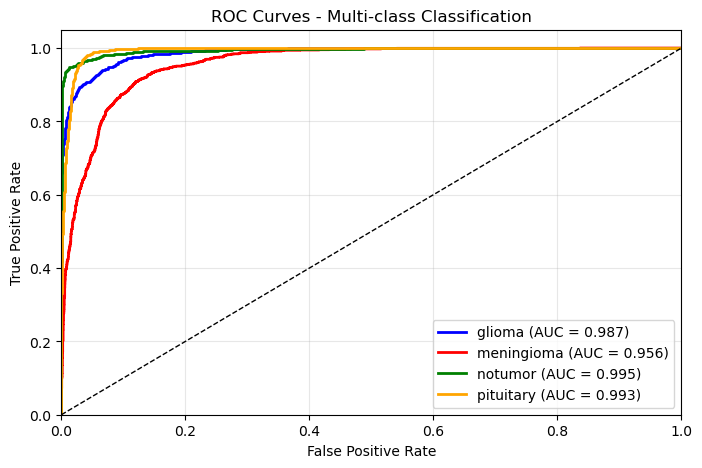

In [76]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))

# Plot ROC curves
plt.figure(figsize=(8, 5))
colors = ['blue', 'red', 'green', 'orange']

for i, (class_name, color) in enumerate(zip(label_encoder.classes_, colors)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=color, linewidth=2,
            label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Multi-class Classification')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

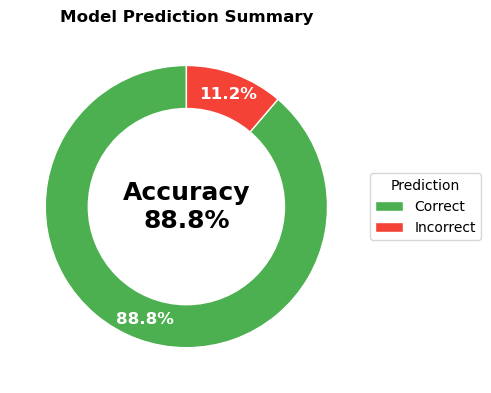

In [75]:
# Model Prediction Summary
# Calculate counts
correct = (y_pred == y_test).sum()
incorrect = (y_pred != y_test).sum()
total = correct + incorrect

sizes = [correct, incorrect]
labels = ['Correct', 'Incorrect']
colors = ['#4CAF50', '#F44336']  # green for correct, red for incorrect

fig, ax = plt.subplots(figsize=(5,5))
wedges, texts, autotexts = ax.pie(
    sizes,
    colors=colors,
    startangle=90,
    wedgeprops=dict(width=0.4, edgecolor='white'),
    autopct='%1.1f%%',
    pctdistance=0.85,
    textprops={'fontsize': 12, 'color': 'white', 'weight': 'bold'}
)

# Draw center circle for doughnut effect
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# Add accuracy text in the center
accuracy = correct / total * 100
ax.text(0, 0, f'Accuracy\n{accuracy:.1f}%', ha='center', va='center', fontsize=18, fontweight='bold')

# Add legend
plt.legend(wedges, labels, title="Prediction", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)

plt.title("Model Prediction Summary", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

<h4 style="color:coral;">Model Testing Predictions & Ananlysis</h4>

Random Sample Predictions:


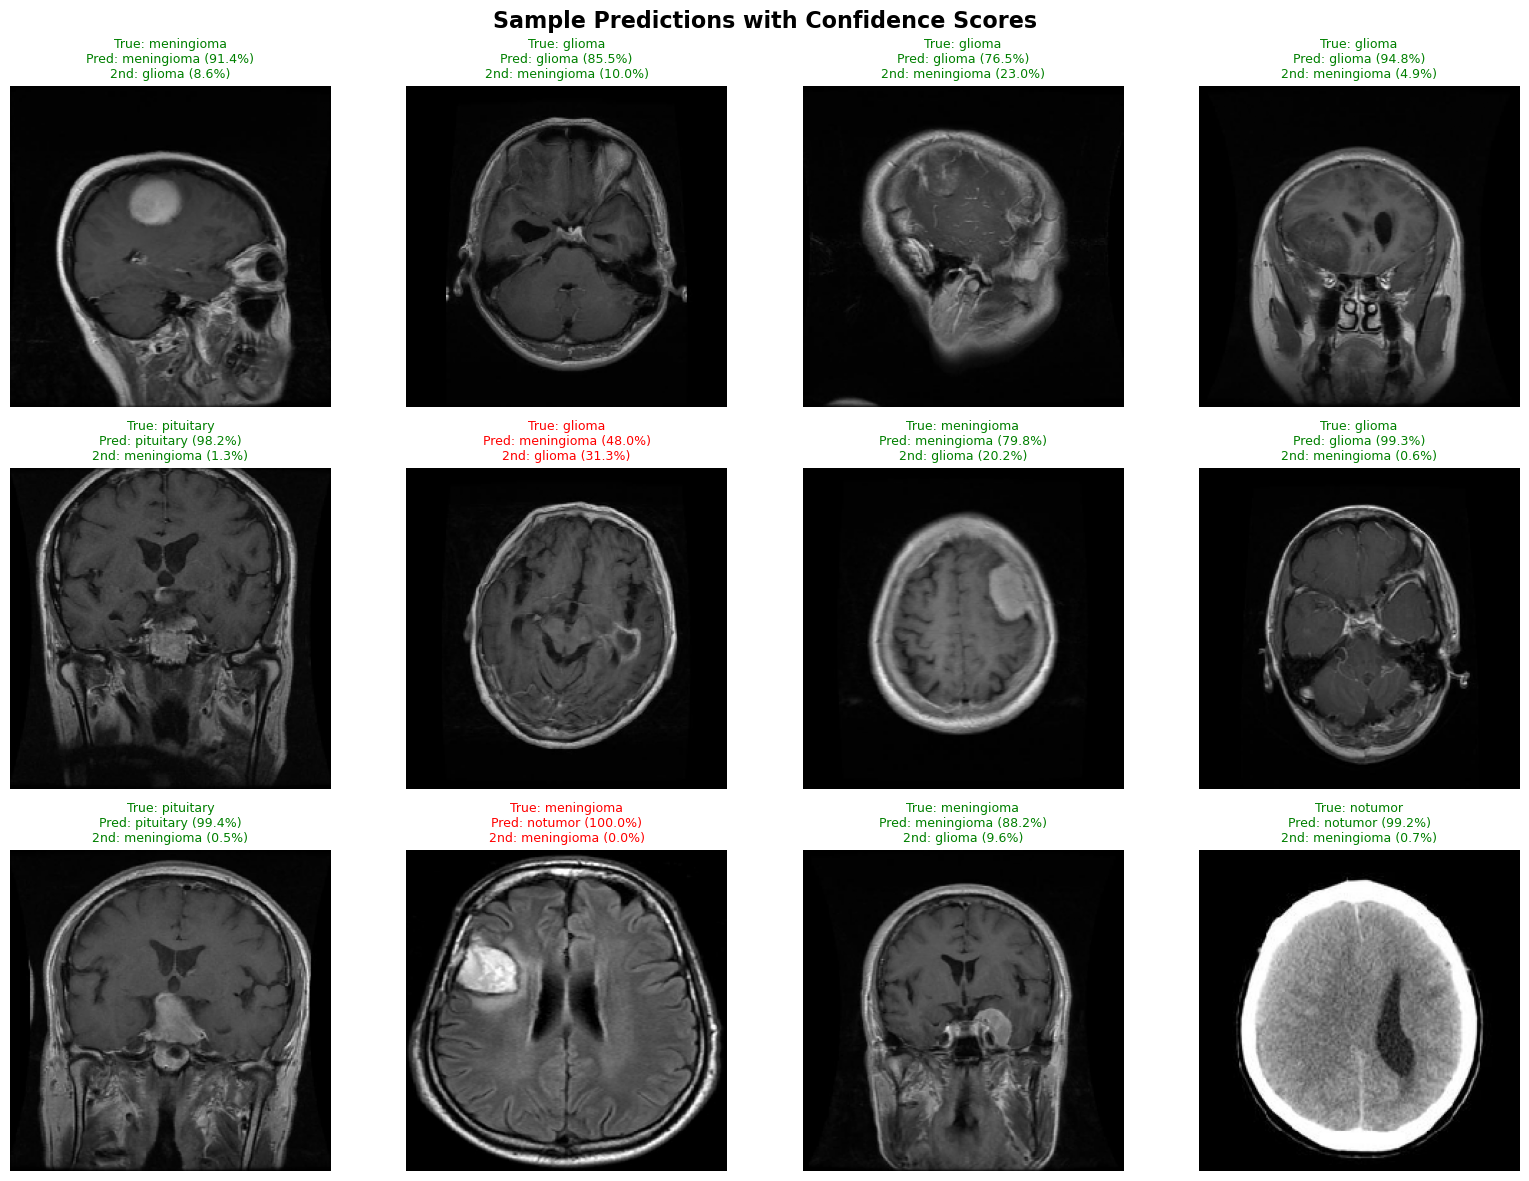

In [49]:
# Sample Predictions & Analysis

# Sample predictions with confidence scores
def visualize_predictions_with_confidence(images, y_true, y_pred, y_pred_prob, class_names, num_samples=12):
    # Select random samples
    indices = np.random.choice(len(images), num_samples, replace=False)
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        img = images[idx]
        true_class = class_names[y_true[idx]]
        pred_class = class_names[y_pred[idx]]
        confidence = y_pred_prob[idx][y_pred[idx]] * 100
        
        # Get top 2 predictions
        top_2_indices = np.argsort(y_pred_prob[idx])[-2:][::-1]
        top_2_probs = y_pred_prob[idx][top_2_indices] * 100
        
        axes[i].imshow(img)
        axes[i].axis('off')
        
        # Color coding
        color = 'green' if y_true[idx] == y_pred[idx] else 'red'
        
        # Title with confidence
        title = f'True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)'
        if len(top_2_indices) > 1:
            second_class = class_names[top_2_indices[1]]
            title += f'\n2nd: {second_class} ({top_2_probs[1]:.1f}%)'
        
        axes[i].set_title(title, color=color, fontsize=9)
    
    plt.suptitle('Sample Predictions with Confidence Scores', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Run Sample Prediction
print("Random Sample Predictions:")
visualize_predictions_with_confidence(X_test, y_test, y_pred, y_pred_prob, label_encoder.classes_)

Highest Confidence Correct Predictions:


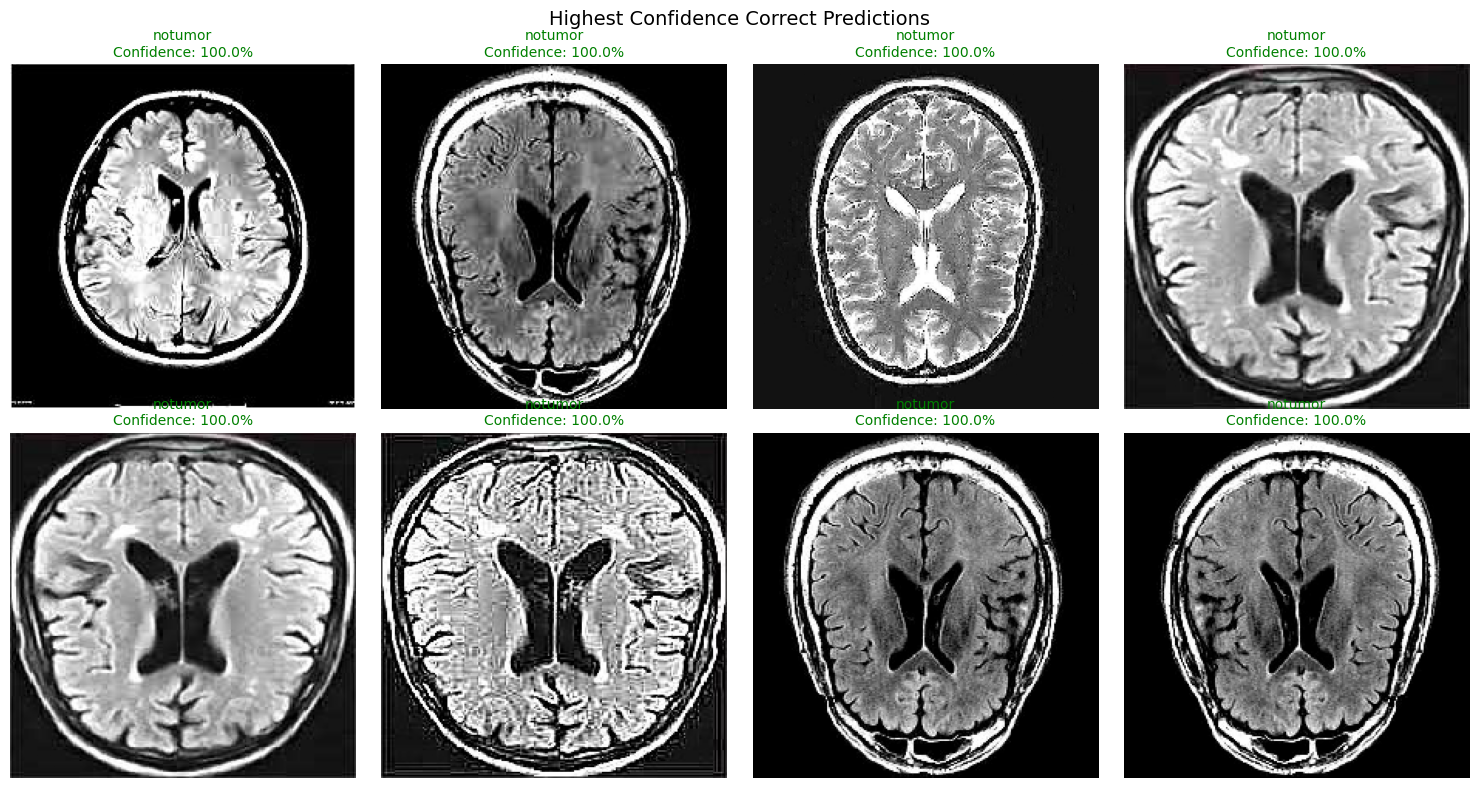

In [52]:
# Show correct predictions
def show_high_confidence_correct(images, y_true, y_pred, y_pred_prob, class_names, num_samples=8):
    # Find correct predictions with high confidence
    correct_mask = y_true == y_pred
    correct_indices = np.where(correct_mask)[0]
    correct_confidences = y_pred_prob[correct_indices, y_pred[correct_indices]]
    
    # Get highest confidence correct predictions
    top_confident = correct_indices[np.argsort(correct_confidences)[-num_samples:]]
    
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(top_confident):
        img = images[idx]
        true_class = class_names[y_true[idx]]
        confidence = y_pred_prob[idx][y_pred[idx]] * 100
        
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'{true_class}\nConfidence: {confidence:.1f}%', 
                         color='green', fontsize=10)
    
    plt.suptitle('Highest Confidence Correct Predictions', fontsize=14)
    plt.tight_layout()
    plt.show()
    
print("Highest Confidence Correct Predictions:")
show_high_confidence_correct(X_test, y_test, y_pred, y_pred_prob, label_encoder.classes_)

Model Mistakes (High Confidence Wrong Predictions):


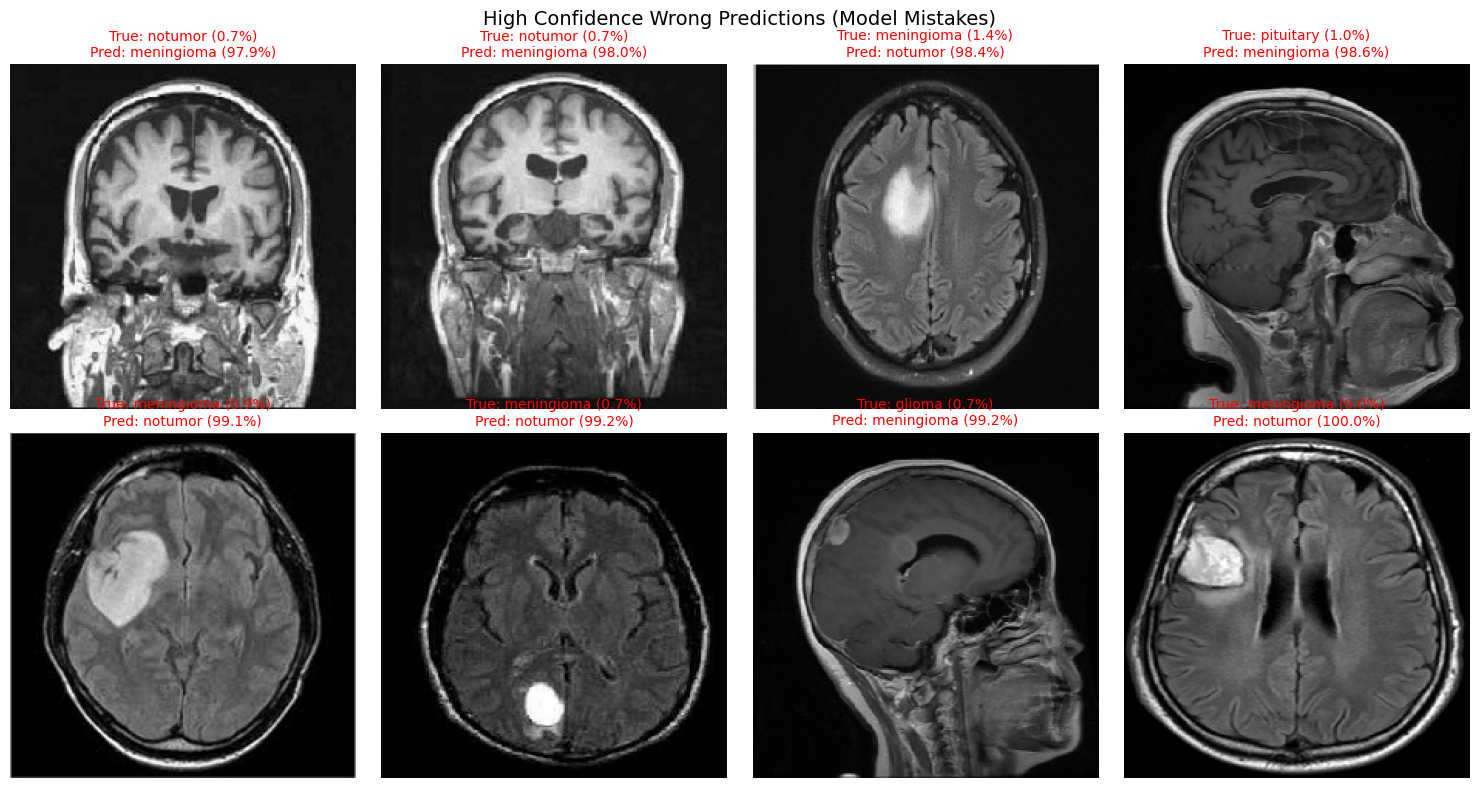

In [54]:
# Confident mistake prediction
def show_confident_mistakes(images, y_true, y_pred, y_pred_prob, class_names, num_samples=8):
    # Find wrong predictions
    wrong_mask = y_true != y_pred
    wrong_indices = np.where(wrong_mask)[0]
    
    if len(wrong_indices) == 0:
        print("No wrong predictions found!")
        return
    
    # Confidence in the wrong prediction
    wrong_confidences = y_pred_prob[wrong_indices, y_pred[wrong_indices]]
    
    # Get indices of the highest confidence wrong predictions
    if len(wrong_indices) >= num_samples:
        top_wrong_indices = wrong_indices[np.argsort(wrong_confidences)[-num_samples:]]
    else:
        top_wrong_indices = wrong_indices

    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(15, 8))
    axes = axes.ravel()

    for i, idx in enumerate(top_wrong_indices):
        if i >= len(axes):
            break

        img = images[idx]
        true_label = y_true[idx]
        pred_label = y_pred[idx]

        true_class = class_names[true_label]
        pred_class = class_names[pred_label]

        # Get model's confidence in predicted and true class
        pred_conf = y_pred_prob[idx][pred_label] * 100
        true_conf = y_pred_prob[idx][true_label] * 100

        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(
            f'True: {true_class} ({true_conf:.1f}%)\nPred: {pred_class} ({pred_conf:.1f}%)',
            color='red',
            fontsize=10
        )

    # Hide unused subplots
    for j in range(len(top_wrong_indices), len(axes)):
        axes[j].axis('off')

    plt.suptitle('High Confidence Wrong Predictions (Model Mistakes)', fontsize=14)
    plt.tight_layout()
    plt.show()

print("Model Mistakes (High Confidence Wrong Predictions):")
show_confident_mistakes(X_test, y_test, y_pred, y_pred_prob, label_encoder.classes_)

Confidence Distribution Analysis:


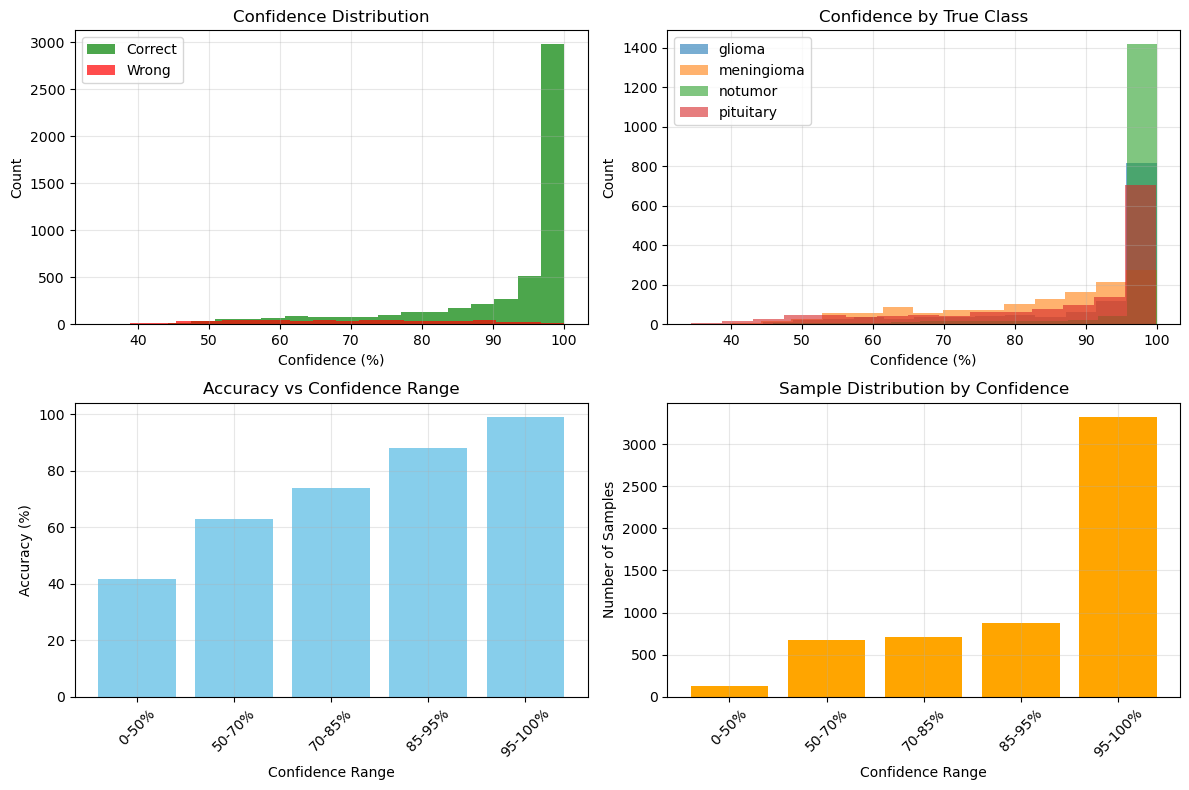

Average confidence (correct): 91.9%
Average confidence (wrong): 69.6%
High confidence (>90%) accuracy: 98.3%


In [55]:
# Confidence distribution analysis
def analyze_confidence_distribution(y_pred_prob, y_true, y_pred, class_names):
    max_confidences = np.max(y_pred_prob, axis=1) * 100
    correct_mask = y_true == y_pred
    
    plt.figure(figsize=(12, 8))
    
    # Overall confidence distribution
    plt.subplot(2, 2, 1)
    plt.hist(max_confidences[correct_mask], alpha=0.7, label='Correct', bins=20, color='green')
    plt.hist(max_confidences[~correct_mask], alpha=0.7, label='Wrong', bins=20, color='red')
    plt.xlabel('Confidence (%)')
    plt.ylabel('Count')
    plt.title('Confidence Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Per-class confidence
    plt.subplot(2, 2, 2)
    for i, class_name in enumerate(class_names):
        class_mask = y_true == i
        class_confidences = max_confidences[class_mask]
        plt.hist(class_confidences, alpha=0.6, label=class_name, bins=15)
    plt.xlabel('Confidence (%)')
    plt.ylabel('Count')
    plt.title('Confidence by True Class')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Confidence vs Accuracy
    plt.subplot(2, 2, 3)
    confidence_ranges = [(0, 50), (50, 70), (70, 85), (85, 95), (95, 100)]
    accuracies = []
    counts = []
    
    for low, high in confidence_ranges:
        mask = (max_confidences >= low) & (max_confidences < high)
        if mask.sum() > 0:
            acc = correct_mask[mask].mean() * 100
            accuracies.append(acc)
            counts.append(mask.sum())
        else:
            accuracies.append(0)
            counts.append(0)
    
    labels = [f'{low}-{high}%' for low, high in confidence_ranges]
    plt.bar(labels, accuracies, color='skyblue')
    plt.xlabel('Confidence Range')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Confidence Range')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    # Sample counts in each range
    plt.subplot(2, 2, 4)
    plt.bar(labels, counts, color='orange')
    plt.xlabel('Confidence Range')
    plt.ylabel('Number of Samples')
    plt.title('Sample Distribution by Confidence')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Average confidence (correct): {max_confidences[correct_mask].mean():.1f}%")
    print(f"Average confidence (wrong): {max_confidences[~correct_mask].mean():.1f}%")
    print(f"High confidence (>90%) accuracy: {correct_mask[max_confidences > 90].mean()*100:.1f}%")

print("Confidence Distribution Analysis:")
analyze_confidence_distribution(y_pred_prob, y_test, y_pred, label_encoder.classes_)

<h4 style="color:coral;">ModelXAI: Grad-CAM based MRI Tumor Explainability Toolkit</h4>

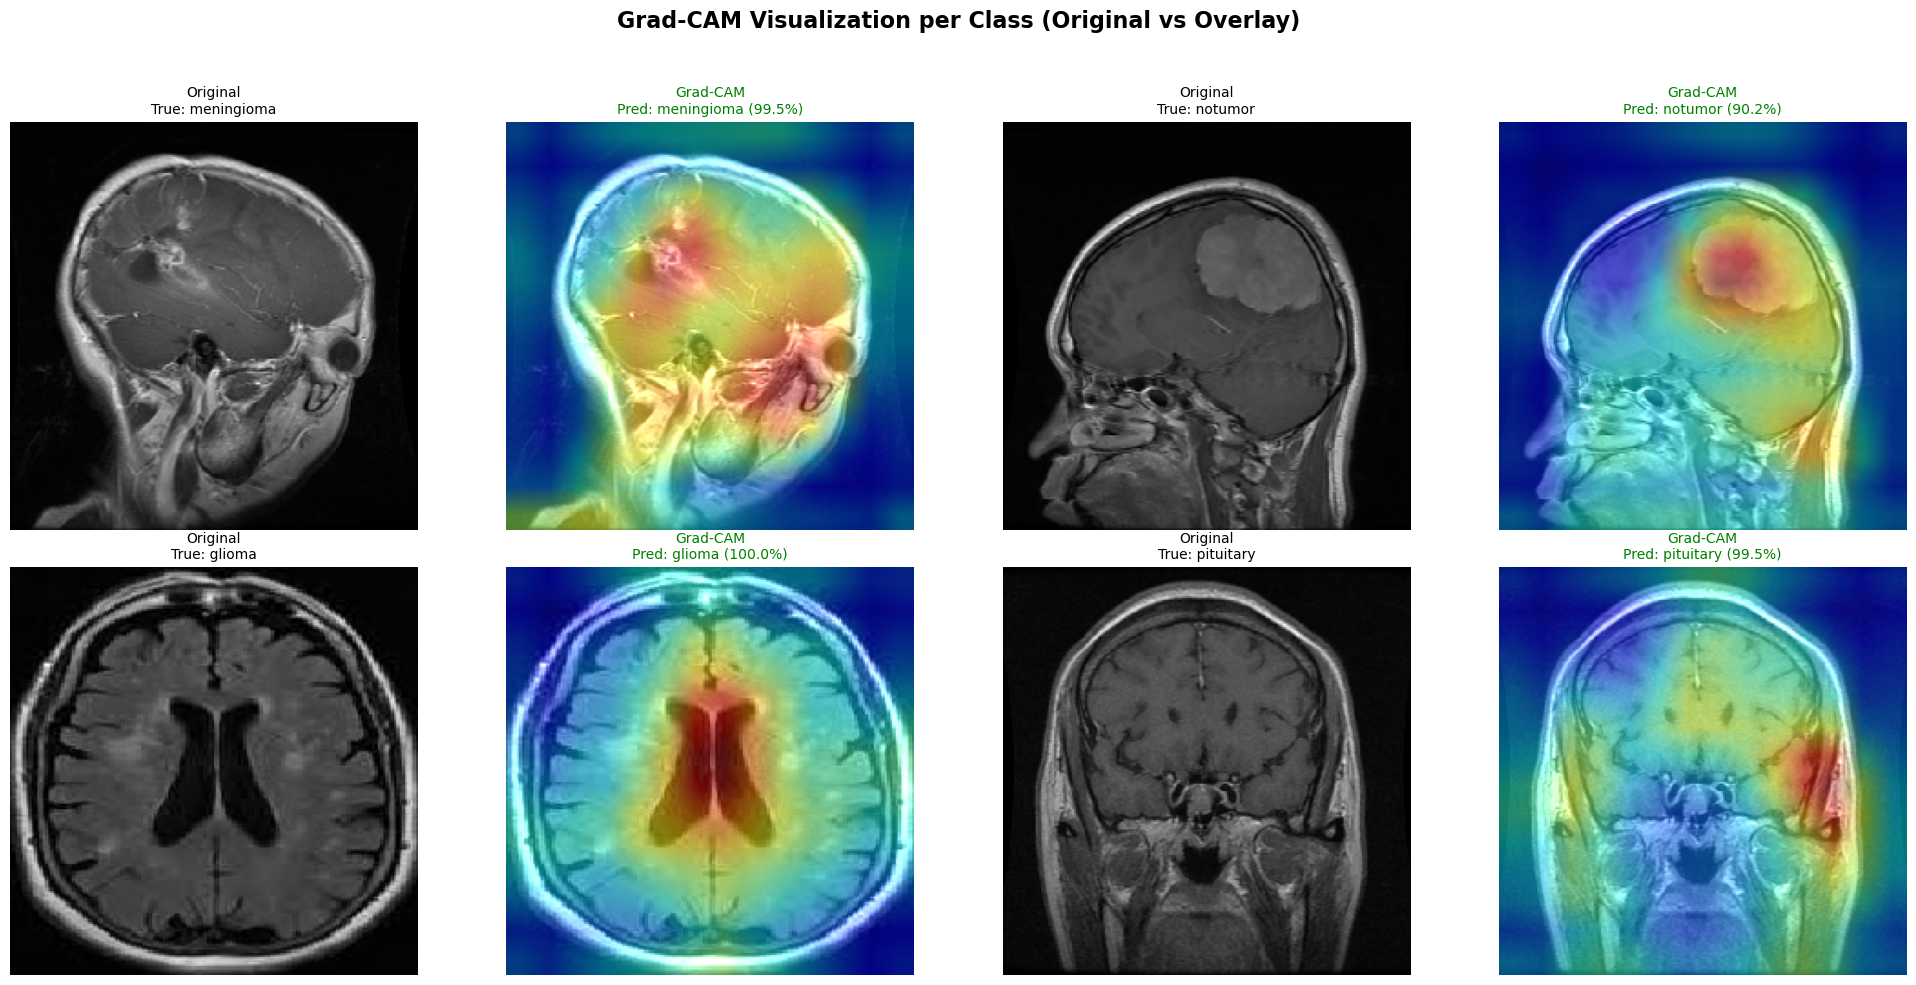

In [60]:
# Grad-CAM (Gradient-weighted Class Activation Mapping) - Visualizing Model Attention

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, idx in enumerate(sample_indices):
    img = X_test[idx]
    img_input = np.expand_dims(img, axis=0)

    preds = model.predict(img_input, verbose=0)[0]
    pred_class = np.argmax(preds)
    confidence = preds[pred_class] * 100
    class_label = class_names[pred_class]
    true_class = class_names[y_test[idx]]

    heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name='block5_conv3', pred_index=pred_class)
    overlayed_img = overlay_gradcam(img, heatmap, alpha=0.5)

    # Original image in even axes positions: 0, 2, 4, 6
    axes[2*i].imshow(img)
    axes[2*i].axis('off')
    axes[2*i].set_title(f"Original\nTrue: {true_class}", fontsize=10)

    # Grad-CAM overlay in odd axes positions: 1, 3, 5, 7
    axes[2*i + 1].imshow(overlayed_img)
    axes[2*i + 1].axis('off')
    color = 'green' if pred_class == y_test[idx] else 'red'
    axes[2*i + 1].set_title(f"Grad-CAM\nPred: {class_label} ({confidence:.1f}%)", fontsize=10, color=color)

plt.suptitle("Grad-CAM Visualization per Class (Original vs Overlay)", fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()